In [3]:
import os
import cv2
import math
import scipy
import numpy as np
import pandas as pd
import nibabel as nib
from PIL import Image
from skimage import measure
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage.transform import resize
from skimage.util import img_as_float
from skimage.segmentation import slic
from scipy.spatial.distance import cdist
from sklearn.metrics import jaccard_score
from skimage.measure import label, regionprops
from openniftiimages import load_and_display_nifti
from scipy.spatial.distance import directed_hausdorff
from skimage.segmentation import find_boundaries, mark_boundaries

In [4]:
patient_info_file = r'G:\Annekoos Schaap - code\Data\All_imaging_features_NKI.xlsx'
base_nifti_path = r'G:\NKI dataset\Data_nifti'

# Read the patient info
patient_info_df = pd.read_excel(patient_info_file)

In [5]:
# read Excel
filename = 'coordinates_429.xlsx'
df = pd.read_excel(filename, sheet_name='Sheet1', header=None)
filename_1 = 'coordinates_1.xlsx'
df_1 = pd.read_excel(filename_1, sheet_name='Sheet1', header=None)
print(df)

print(len(df))
print(len(patient_info_df))

      0    1    2    3      4
0   193  199  370  298  13260
1   137  139  342  276  22008
2   177  197  352  292  12968
3   153  245  352  360  18060
4   175  195  340  316  15068
5   173  205  332  308  13044
6   183  171  324  270  11812
7   161  187  346  318  19204
8   183  201  348  306  13980
9   175  205  348  312  13996
10  177  199  346  334  16816
11  141  209  360  340  22948
12  177  225  366  338  14876
13  143  159  362  330  29352
14  169  189  338  302  14960
15  193  231  346  336  12676
16  159  203  338  310  13868
17  157  215  350  318  16856
18  189  231  336  312  10588
19  175  267  342  384  15516
20  195  233  346  352  14444
21  187  227  342  306   9776
22  183  221  344  320  12516
23  161  171  384  304  23276
24  183  245  346  326   9900
25  173  221  352  342  18156
26   81   92  164  146   3495
27  188   89  387  263  27807
28  203  183  373  331  19795
29  303  295  410  371   5618
30  298  276  415  355   6973
31  284  312  415  412  10643
32  268  2

In [6]:
dice_score_all = []
dice_score_from_jaccard_all = []
hausdorff_dist_all = []
asd_all = []
alpha_all = []
prostate_mask_all = []
predicted_mask_all = []
SLICresult = []
pixel_labels = []

In [7]:
metrics_data = {
    'patient_name': [],
    'alpha': [],
    'dice_score': [],
    'hausdorff_dist': [],
    'asd': [],
    'n_segment': []
}

In [8]:
# Define the threshold
threshold = 0.6

In [9]:
def extract_boundary_points(mask):
    if mask.ndim != 2 or mask.size == 0:
        print("掩模形状无效:", mask.shape)
        return np.array([])  # 如果掩模不是二维或为空，则返回一个空数组

    contours = measure.find_contours(mask, level=0.5)
    points = []
    for contour in contours:
        for point in contour:
            points.append(point)
    return np.array(points)

In [10]:
def calculate_metrics(predicted_mask, prostate_mask):

    # Dice score 
    dice_score = 2 * np.sum(predicted_mask & prostate_mask) / (np.sum(predicted_mask) + np.sum(prostate_mask))

    # Jaccard index Dice score: 2 * Jaccard index / (1 + Jaccard index)
    jaccard_index = jaccard_score(prostate_mask.flatten(), predicted_mask.flatten())
    dice_score_from_jaccard = 2 * jaccard_index / (1 + jaccard_index)

    # Hausdorff distance
    u = np.transpose(np.nonzero(prostate_mask))
    v = np.transpose(np.nonzero(predicted_mask))
    hausdorff_dist = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

    print(prostate_mask.shape)
    print(predicted_mask.shape)

    return dice_score, dice_score_from_jaccard, hausdorff_dist

In [11]:
def calculate_asd(mask1, mask2):
    # 提取两个掩模的边界点
    points1 = extract_boundary_points(mask1)
    points2 = extract_boundary_points(mask2)

    print(points1.shape)
    print(points2.shape)

    # 如果任一点集为空，返回NaN
    if points1.size == 0 or points2.size == 0:
        return np.nan
    
    # 计算点集之间的距离
    distances_1_to_2 = cdist(points1, points2, metric='euclidean')
    distances_2_to_1 = cdist(points2, points1, metric='euclidean')
    
    # 找到最短距离并计算平均值
    min_distances_1_to_2 = np.min(distances_1_to_2, axis=1)
    min_distances_2_to_1 = np.min(distances_2_to_1, axis=1)
    
    # 计算两个方向的平均表面距离
    asd_1_to_2 = np.mean(min_distances_1_to_2)
    asd_2_to_1 = np.mean(min_distances_2_to_1)
    
    # 返回双向平均表面距离
    return (asd_1_to_2 + asd_2_to_1) / 2

In [12]:
import scipy.io
# 读取 .mat 文件
mat_data = scipy.io.loadmat('tumor_coordinates.mat')
# 提取 'coordinates_all' 变量
coordinates_all = mat_data['coordinates_all']

In [13]:
tumor_coordinates = coordinates_all[3]
new_coordinates = tumor_coordinates[0]
# min_row, min_col = np.min(tumor_coordinates, axis=0)
# max_row, max_col = np.max(tumor_coordinates, axis=0)
# matrix = np.zeros((max_row - min_row + 1, max_col - min_col + 1), dtype=int)
# for coord in tumor_coordinates:
#     row, col = coord
#     matrix[row - min_row, col - min_col] = 1
# new_coordinates = np.argwhere(matrix == 1)
# new_coordinates += [min_col, min_row]

In [14]:
print(new_coordinates)

[[110  45]
 [111  45]
 [112  45]
 ...
 [122  91]
 [123  91]
 [124  91]]


In [15]:
from skimage.measure import find_contours

Processing MRI009, Slice 12...
uint8 (150, 239)


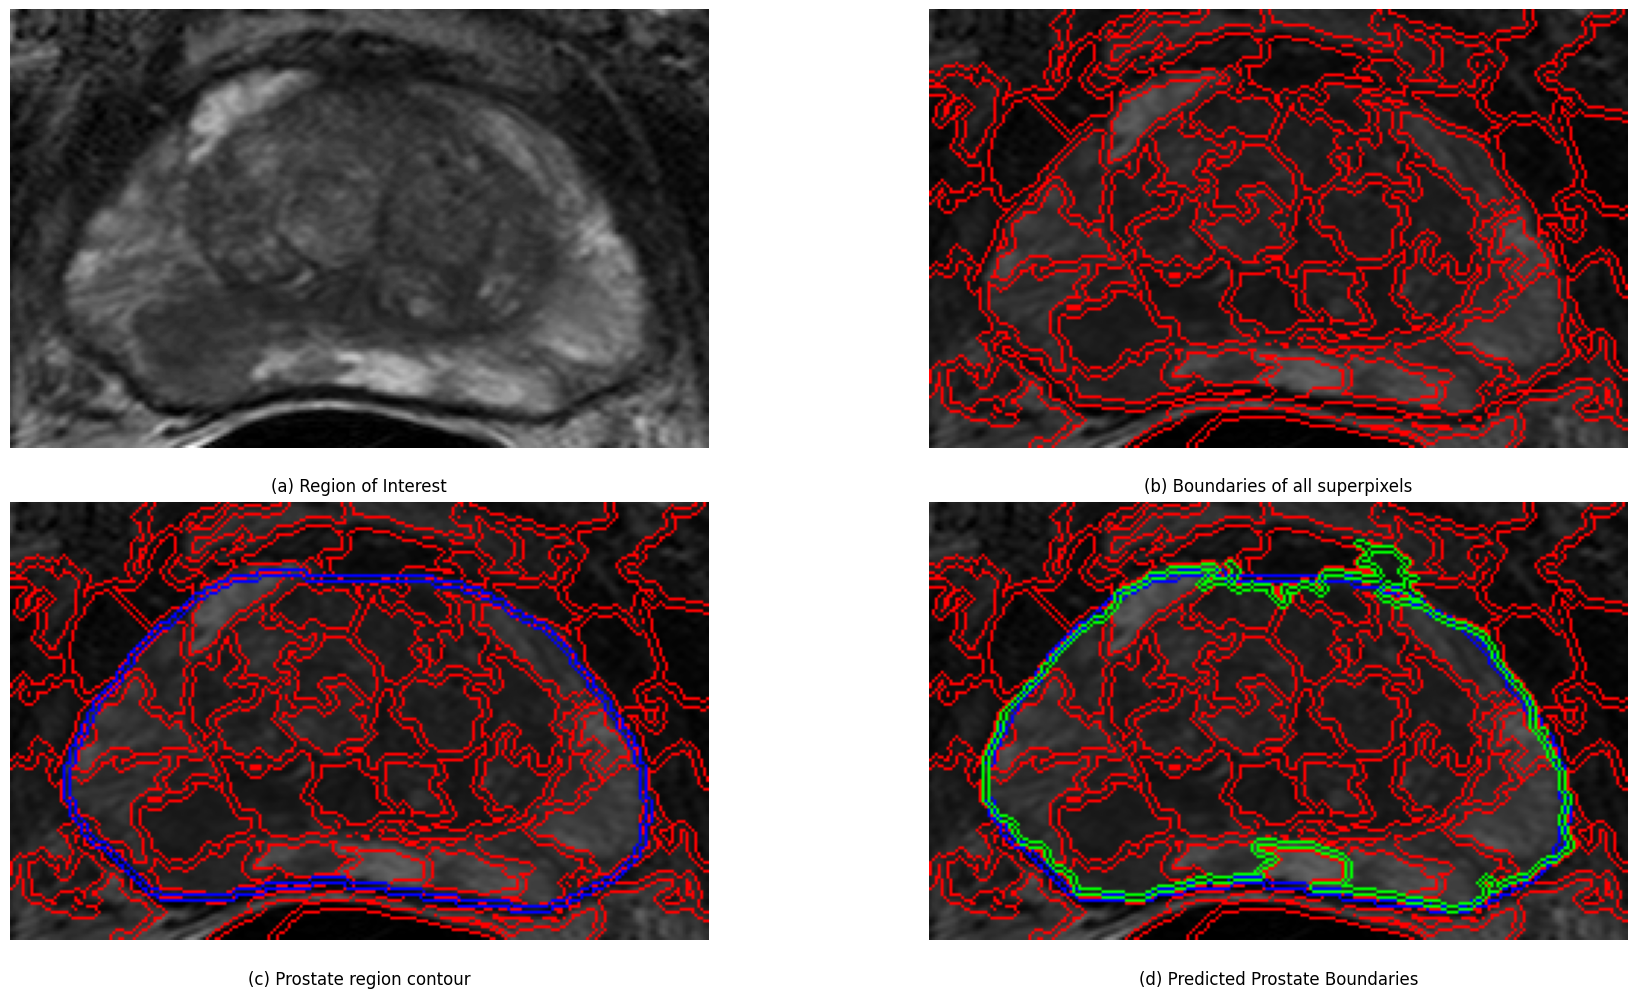

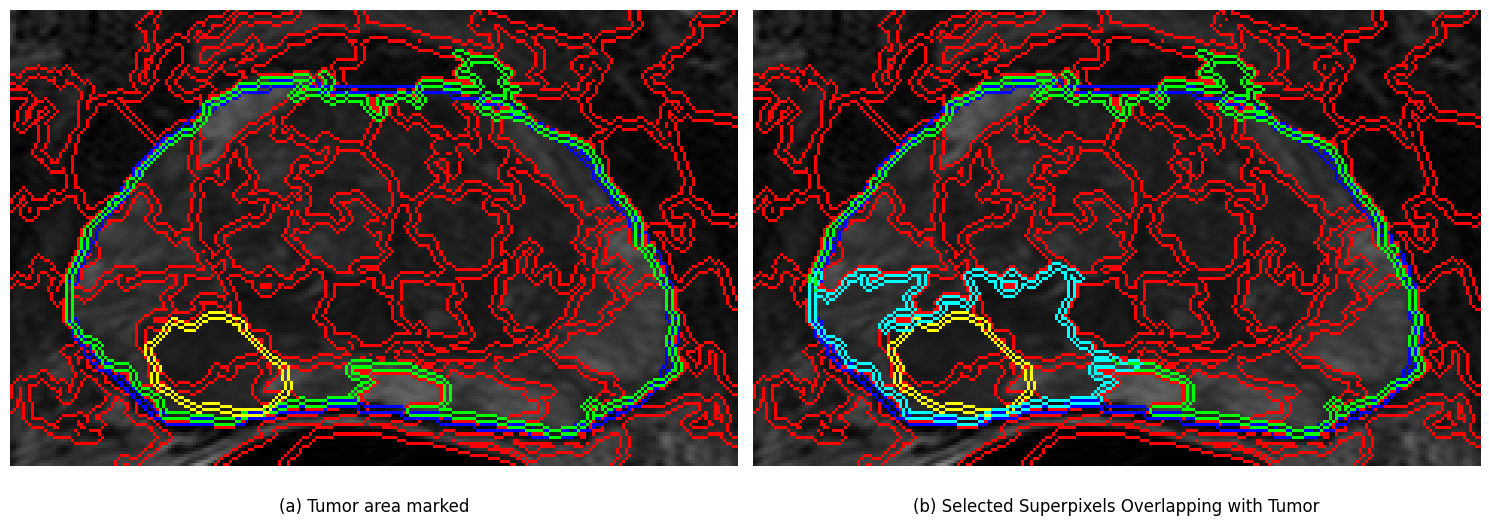

In [16]:
patient_name = 'MRI009'
slice_no = 12
print(f"Processing {patient_name}, Slice {slice_no}...")
# Construct the path to the NIfTI file
nifti_path = os.path.join(base_nifti_path, patient_name, 'NIFTIs', 'T2.nii')
    
# Load the NIfTI image
nifti_image = nib.load(nifti_path)
data_nifti = nifti_image.get_fdata()

if data_nifti.ndim == 3:
    # Get the specific slice
    image_slice = data_nifti[:, :, slice_no - 1]
    
    # Process the image slice
    image_nifti = np.rot90(image_slice, 3)
    image_nifti = np.fliplr(image_nifti)
    minni = np.min(image_nifti)
    maxni = np.max(image_nifti)
    rescaled_image = ((image_nifti - minni) / (maxni - minni)) * 255
    rescaled_image = rescaled_image.astype(np.uint8)

    minX, minY, maxX, maxY = df.iloc[3, :4]

    y_min = minY - 25
    # y_max = min(maxY + 10, rescaled_image.shape[0])
    y_max = maxY + 10
    x_min = minX - 20
    # x_max = min(maxX + 20, rescaled_image.shape[1])
    x_max = maxX + 20
    area = rescaled_image[y_min:y_max, x_min:x_max]

    mat_file_path = os.path.join(r'C:\Users\alexg\Desktop\study\graduation project\code\prostate_ROI_429', f'{patient_name}_{slice_no}_prostate_ROI.png')
    image = cv2.imread(mat_file_path, cv2.IMREAD_GRAYSCALE)
    prostate_mask = image.astype(bool)

    prostate_mask_all = prostate_mask

    prostate_mask = prostate_mask[y_min:y_max, x_min:x_max]

    if prostate_mask.shape != area.shape:
        prostate_mask = resize(prostate_mask, area.shape, order=0, preserve_range=True, anti_aliasing=False).astype(bool)

    segments = slic(area, n_segments=89, compactness=0.05, sigma=1, start_label=1, channel_axis=None)
    boundaries_1 = find_boundaries(segments, mode='inner')
    image_with_boundaries_1 = mark_boundaries(area, boundaries_1, color=(1, 0, 0))

    predicted_mask = np.zeros_like(prostate_mask)
    overlapping_superpixels = np.zeros_like(segments, dtype=bool)
    print(area.dtype, area.shape)
    
    for region in regionprops(label(segments)):
        # Extract the superpixel region
        superpixel = (segments == region.label)
        
        # Calculate overlap with the prostate mask
        overlap = np.sum(superpixel & prostate_mask) / np.sum(superpixel)
        
        # If overlap exceeds the threshold, consider it as part of the prostate
        if overlap > threshold:
            predicted_mask[superpixel] = 1

    tumor_mask = np.zeros_like(area, dtype=bool)

    # contours = find_contours(cropped_tumor, level=0.5)

    for coord in new_coordinates:
        tumor_y, tumor_x = coord[0], coord[1]
        if 0 <= tumor_y < tumor_mask.shape[0] and 0 <= tumor_x < tumor_mask.shape[1]:
            tumor_mask[tumor_y, tumor_x] = 1

    for region in regionprops(label(segments)):
        # Extract the superpixel region
        superpixel = (segments == region.label)
        
        # Calculate overlap with the prostate mask
        overlap = np.sum(superpixel & tumor_mask) / np.sum(superpixel)
        
        # If overlap exceeds the threshold, consider it as part of the prostate
        if overlap > 0:
            overlapping_superpixels[superpixel] = 1

    boundaries_2 = find_boundaries(prostate_mask, mode='inner')
    boundaries_3 = find_boundaries(predicted_mask, mode='inner')
    tumor_boundaries = find_boundaries(tumor_mask, mode='inner')
    overlapping_boundaries = find_boundaries(overlapping_superpixels, mode='inner')

    image_with_boundaries_2 = mark_boundaries(image_with_boundaries_1, boundaries_2, color=(0, 0, 1))
    image_with_boundaries_3 = mark_boundaries(image_with_boundaries_2, boundaries_3, color=(0, 1, 0))
    image_with_boundaries_4 = mark_boundaries(image_with_boundaries_3, tumor_boundaries, color=(1, 1, 0))
    image_with_overlapping_boundaries = mark_boundaries(image_with_boundaries_4, overlapping_boundaries, color=(0, 1, 1)) 

    # Plot the first set of images
fig_1, axes_1 = plt.subplots(2, 2, figsize=(20, 10))

titles_1 = [
    "(a) Region of Interest",
    "(b) Boundaries of all superpixels",
    "(c) Prostate region contour",
    "(d) Predicted Prostate Boundaries"
]

axes_1[0,0].imshow(area, cmap='gray')
axes_1[0,0].axis('off')
axes_1[0,0].text(0.5, -0.1, titles_1[0], fontsize=12, ha='center', transform=axes_1[0,0].transAxes)

axes_1[0,1].imshow(image_with_boundaries_1, cmap='gray')
axes_1[0,1].axis('off')
axes_1[0,1].text(0.5, -0.1, titles_1[1], fontsize=12, ha='center', transform=axes_1[0,1].transAxes)

axes_1[1,0].imshow(image_with_boundaries_2, cmap='gray')
axes_1[1,0].axis('off')
axes_1[1,0].text(0.5, -0.1, titles_1[2], fontsize=12, ha='center', transform=axes_1[1,0].transAxes)

axes_1[1,1].imshow(image_with_boundaries_3, cmap='gray')
axes_1[1,1].axis('off')
axes_1[1,1].text(0.5, -0.1, titles_1[3], fontsize=12, ha='center', transform=axes_1[1,1].transAxes)

plt.tight_layout()
plt.show()

# Plot the second set of images
fig_2, axes_2 = plt.subplots(1, 2, figsize=(15, 10))

titles_2 = [
    "(a) Tumor area marked",
    "(b) Selected Superpixels Overlapping with Tumor"
]

axes_2[0].imshow(image_with_boundaries_4, cmap='gray')
axes_2[0].axis('off')
axes_2[0].text(0.5, -0.1, titles_2[0], fontsize=12, ha='center', transform=axes_2[0].transAxes)

axes_2[1].imshow(image_with_overlapping_boundaries, cmap='gray')
axes_2[1].axis('off')
axes_2[1].text(0.5, -0.1, titles_2[1], fontsize=12, ha='center', transform=axes_2[1].transAxes)

plt.tight_layout()
plt.show()


    # # Plot images
    # fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    # # axes[0,0].imshow(image_nifti, cmap='gray')
    # # axes[0,0].set_title("Original NIfTI Image")
    # # axes[0,0].axis('off')
    # titles_1 = [
    # "(a) Region of Interest",
    # "(b) Boundaries of all superpixels",
    # "(c) Prostate region contour",
    # "(d) Predicted Prostate Boundaries"
    # ]

    # titles_2 = [
    # "(a) tumor area marked",
    # "(b) Selected Superpixels Overlapping with Tumor"
    # ]

    # axes[0].imshow(area, cmap='gray')
    # axes[0].axis('off')
    # axes[0].text(0.5, -0.1, titles[0], fontsize=12, ha='center', transform=axes[0].transAxes)

    # axes[1].imshow(image_with_boundaries_3, cmap='gray')
    # axes[1].axis('off')
    # axes[1].text(0.5, -0.1, titles[1], fontsize=12, ha='center', transform=axes[1].transAxes)

    # axes[2].imshow(image_with_overlapping_boundaries, cmap='gray')
    # axes[2].axis('off')
    # axes[2].text(0.5, -0.1, titles[2], fontsize=12, ha='center', transform=axes[2].transAxes)

    # plt.tight_layout()
    # plt.show()



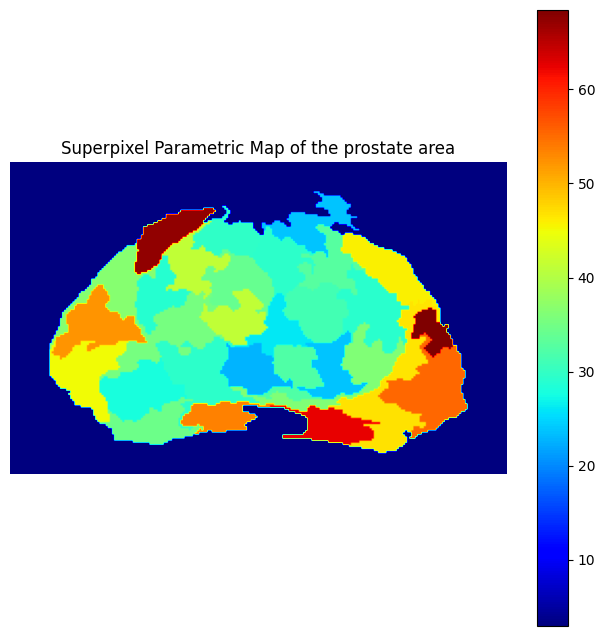

In [40]:
# 创建一个与区域大小相同的零数组用于存储参数图
superpixel_parametric_map = np.zeros_like(area, dtype=np.float32)

# 计算每个超像素的平均亮度值并赋值给superpixel_parametric_map
for region in regionprops(label(segments)):
    superpixel = (segments == region.label)
    mean_intensity = np.mean(area[superpixel])
    superpixel_parametric_map[superpixel] = mean_intensity

# 仅标注boundaries_3内的superpixel颜色
masked_parametric_map = np.zeros_like(superpixel_parametric_map)

# 提取boundaries_3内的区域
for region in regionprops(label(segments)):
    superpixel = (segments == region.label)
    if np.any(predicted_mask[superpixel]):
        masked_parametric_map[superpixel] = superpixel_parametric_map[superpixel]

# 映射到彩色（将未标注区域设为黑色或灰色）
plt.figure(figsize=(8, 8))
plt.imshow(masked_parametric_map, cmap='jet', vmin=np.min(superpixel_parametric_map), vmax=np.max(superpixel_parametric_map))
plt.colorbar()
plt.title("Superpixel Parametric Map of the prostate area")
plt.axis('off')
plt.show()


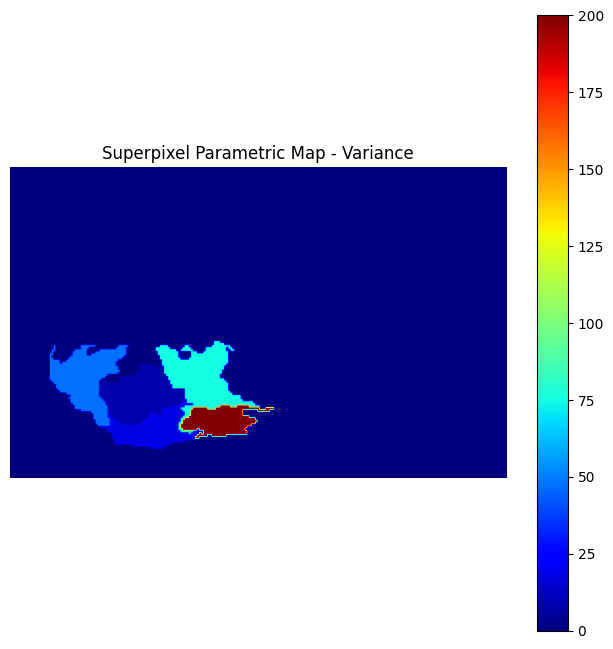

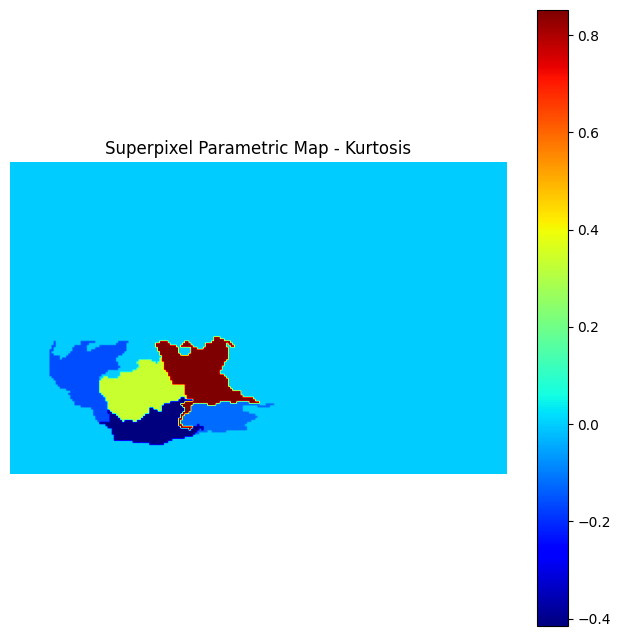

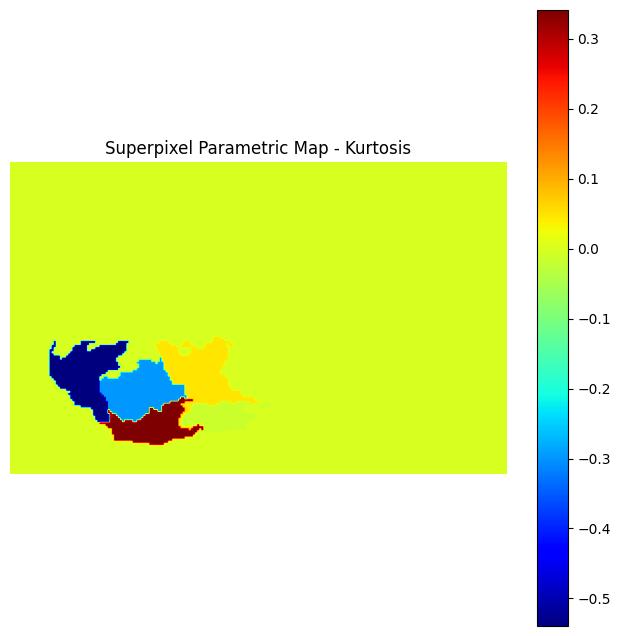

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import nibabel as nib
from skimage.segmentation import slic, mark_boundaries, find_boundaries
from skimage.measure import regionprops, label
from skimage.transform import resize

def calculate_statistics(pixel_values):
    """Calculate variance, skewness, and kurtosis for a given array of pixel values."""
    # Calculate mean
    u = np.mean(pixel_values)
    
    # Calculate variance
    variance = np.mean((pixel_values - u) ** 2)
    sigma = np.sqrt(variance)
    
    # Calculate skewness
    skewness = np.mean((pixel_values - u) ** 3) / sigma**3
    
    # Calculate kurtosis
    kurtosis = np.mean((pixel_values - u) ** 4) / sigma**4 - 3
    
    return variance, skewness, kurtosis


# 生成SLIC超像素
segments = slic(area, n_segments=89, compactness=0.05, sigma=1, start_label=1, channel_axis=None)

# 创建用于存储方差、偏度和峰度的数组
variance_map = np.zeros_like(area, dtype=np.float32)
skewness_map = np.zeros_like(area, dtype=np.float32)
kurtosis_map = np.zeros_like(area, dtype=np.float32)

# 计算每个超像素的方差、偏度和峰度并存储
for region in regionprops(label(segments)):
    superpixel = (segments == region.label)
    pixel_values = area[superpixel]
    variance, skewness, kurtosis = calculate_statistics(pixel_values)
    variance_map[superpixel] = variance
    skewness_map[superpixel] = skewness
    kurtosis_map[superpixel] = kurtosis

# # 仅标注boundaries_3内的superpixel颜色
# masked_parametric_map_v = np.zeros_like(variance_map)
# masked_parametric_map_s = np.zeros_like(skewness_map)
# masked_parametric_map_k = np.zeros_like(kurtosis_map)

masked_parametric_map_v = np.full_like(variance_map, fill_value=0, dtype=np.float32)
masked_parametric_map_s = np.full_like(skewness_map, fill_value=0, dtype=np.float32)
masked_parametric_map_k = np.full_like(kurtosis_map, fill_value=0, dtype=np.float32)

# 提取boundaries_3内的区域
for region in regionprops(label(segments)):
    superpixel = (segments == region.label)
    if np.any(overlapping_superpixels[superpixel]):
        masked_parametric_map_v[superpixel] = variance_map[superpixel]
        masked_parametric_map_s[superpixel] = skewness_map[superpixel]
        masked_parametric_map_k[superpixel] = kurtosis_map[superpixel]
        

# 打印和显示结果的函数
def display_map(parametric_map, title, cmap='jet'):
    plt.figure(figsize=(8, 8))
    plt.imshow(parametric_map, cmap=cmap, vmin=np.min(parametric_map), vmax=np.max(parametric_map))
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()

# 打印和显示每个统计量的图像
display_map(masked_parametric_map_v, "Superpixel Parametric Map - Variance")
display_map(masked_parametric_map_s, "Superpixel Parametric Map - Kurtosis")
display_map(masked_parametric_map_k, "Superpixel Parametric Map - Kurtosis")


In [39]:
# 创建一个与区域大小相同的零数组用于存储参数图
superpixel_parametric_map = np.zeros_like(area, dtype=np.float32)

# 计算每个超像素的平均亮度值并赋值给superpixel_parametric_map
for region in regionprops(label(segments)):
    superpixel = (segments == region.label)
    mean_intensity = np.mean(area[superpixel])
    superpixel_parametric_map[superpixel] = mean_intensity

# 初始化带有原始灰度图像的图像
colored_map = cv2.cvtColor(area, cv2.COLOR_GRAY2RGB)

# 在overlapping_superpixels内显示彩色参数图
for region in regionprops(label(segments)):
    superpixel = (segments == region.label)
    if np.any(overlapping_superpixels[superpixel]):
        # 将参数值映射到彩色空间
        color_value = plt.cm.jet((superpixel_parametric_map[superpixel] - np.min(superpixel_parametric_map)) /
                                    (np.max(superpixel_parametric_map) - np.min(superpixel_parametric_map)))
        color_value = (color_value[:, :3] * 255).astype(np.uint8)  # 转换为0-255范围的RGB值
        
        # 将彩色值应用到superpixel区域
        colored_map[superpixel] = color_value[superpixel]

# 显示结果
plt.figure(figsize=(8, 8))
plt.imshow(colored_map)
plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), label='Mean Intensity')
plt.title("Superpixel Parametric Map over Grayscale Area")
plt.axis('off')
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 852 but corresponding boolean dimension is 150

In [37]:
superpixel_parametric_map = np.zeros_like(area, dtype=np.float32)

# 计算每个超像素的平均亮度值并赋值给superpixel_parametric_map
for region in regionprops(label(segments)):
    superpixel = (segments == region.label)
    mean_intensity = np.mean(area[superpixel])
    superpixel_parametric_map[superpixel] = mean_intensity

# 初始化带有原始灰度图像的图像
gray_area = cv2.cvtColor(area, cv2.COLOR_GRAY2RGB)
color_map = np.zeros_like(gray_area, dtype=np.float32)

# 在overlapping_superpixels内显示彩色参数图
for region in regionprops(label(segments)):
    superpixel = (segments == region.label)
    if np.any(overlapping_superpixels[superpixel]):
        # 将参数值映射到彩色空间
        color_value = plt.cm.jet((superpixel_parametric_map[superpixel] - np.min(superpixel_parametric_map)) /
                                    (np.max(superpixel_parametric_map) - np.min(superpixel_parametric_map)))
        color_value = (color_value[:, :3] * 255).astype(np.uint8)  # 转换为0-255范围的RGB值
        
        # 将彩色值应用到superpixel区域
        colored_map[superpixel] = color_value[superpixel]

# 映射到彩色（将未标注区域设为黑色或灰色）
plt.figure(figsize=(8, 8))
plt.imshow(colored_map)
plt.colorbar()
plt.title("Superpixel Parametric Map of the Overlapping Superpixels")
plt.axis('off')
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 852 but corresponding boolean dimension is 150

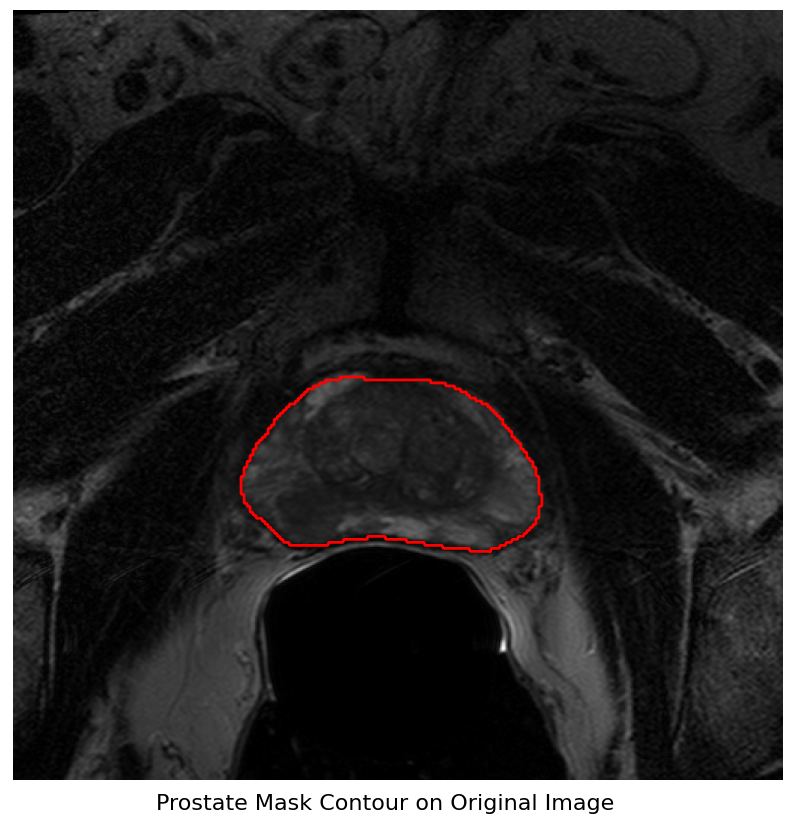

In [18]:
contours = find_contours(prostate_mask_all, level=0.5)

# 2. 显示原图并绘制轮廓
plt.figure(figsize=(10, 10))
plt.imshow(rescaled_image, cmap='gray')
plt.axis('equal')
plt.axis('off')

# 3. 将轮廓绘制在原图上
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], color='red', linewidth=2)

# 4. 设置图片的标题在下方
plt.figtext(0.5, 0.08, 'Prostate Mask Contour on Original Image', ha='center', fontsize=16)

# 5. 打印并显示结果
plt.show()

In [19]:
for coord in new_coordinates:
        tumor_y, tumor_x = coord[0] - minY, coord[1] - minX
        if 0 <= tumor_y < tumor_mask.shape[0] and 0 <= tumor_x < tumor_mask.shape[1]:
            tumor_mask[tumor_y, tumor_x] = 1

In [20]:
print(tumor_mask)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [21]:
true_indices = np.where(tumor_mask)
print(true_indices)

(array([100, 100, 100, ..., 132, 132, 132], dtype=int64), array([65, 66, 67, ..., 80, 81, 82], dtype=int64))


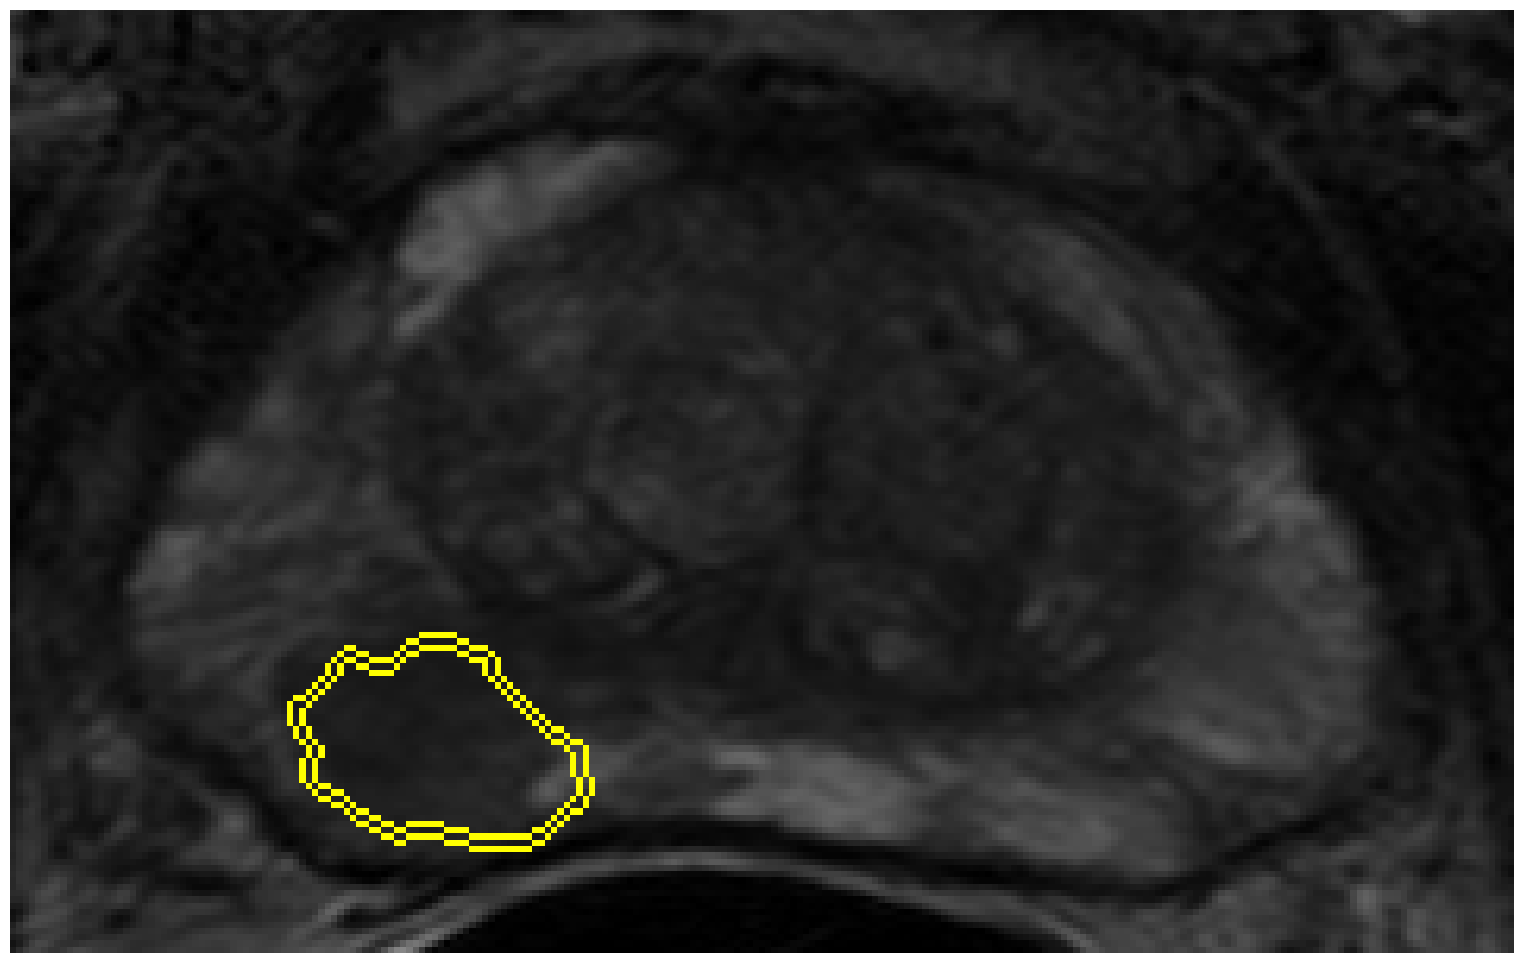

In [22]:
image_with_boundaries_4 = mark_boundaries(area, tumor_boundaries, color=(1, 1, 0))

plt.figure(figsize=(20, 10))
plt.imshow(image_with_boundaries_4, cmap='gray')
plt.tight_layout()
plt.axis('off')
plt.show()